# Finding the best fit rotational broadening and radial velocity

Often in astronomy we have a data spectrum and we want to answer the question:  
*What is the best fit $v\sin{i}$ and RV for this data?*

In this demo we will show some simple ways to use `gollum` to find the model with the best fit rotational broadening and radial velocity, assuming a fixed template.

In [1]:
from gollum.phoenix import PHOENIXSpectrum, PHOENIXGrid
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
%config InlineBackend.figure_format='retina'

### For this demo we will need some real world example data

Let's use data of an A0V star from [HPF](https://hpf.psu.edu) and our sibling package [muler](https://muler.readthedocs.io/en/latest/).  

You can get free example data from the [muler example data GitHub repository](https://github.com/OttoStruve/muler_example_data).

In [2]:
from muler.hpf import HPFSpectrumList, HPFSpectrum

In [3]:
local_file = '../../../muler_example_data/HPF/01_A0V_standards/Goldilocks_20210517T054403_v1.0_0060.spectra.fits'
raw_data = HPFSpectrumList.read(local_file)

In [4]:
def data_clean(data):
    """Clean the HPF data with standard post-processing techniques"""
    data = data.sky_subtract(method='vector')
    data = data.deblaze()
    data = data.trim_edges((4, 2042))
    data = data.normalize()
    data = data.stitch()
    return data

In [5]:
full_data = data_clean(raw_data)

As a final step, we will mask the telluric absorption lines.  This step can sometimes benefit from hand-tuning.

In [6]:
data = full_data.mask_tellurics(threshold=0.999, dilation=13)

We will restrict our fits to the region with the highest density of H lines.

In [7]:
data = data[8500*u.Angstrom:8950*u.Angstrom]
data = data.normalize()

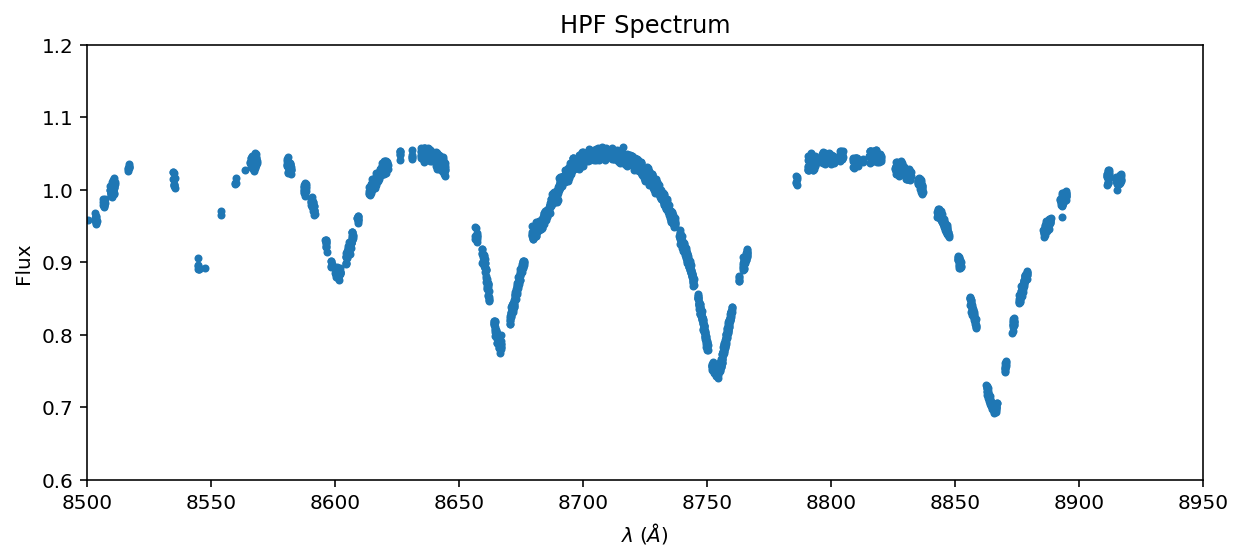

In [8]:
ax = data.plot(marker='.', linestyle='None');
ax.set_xlim(8500, 8950);

OK, that's our data spectrum against which we will compare models.  You can see large voids in the spectrum due to our telluric masking-- that's fine, the data need not be contiguous or evenly sampled to estimate a best fit model.  We will resample the model to the data.

We can choose 3 dimensions in our grid: $T_{\mathrm{eff}}, \log{g}, \left[\frac{\mathrm{Fe}}{\mathrm{H}}\right]$

In [9]:
template = PHOENIXSpectrum(teff=9_600, logg=4.5, metallicity=0)

We then want to rotationally broaden and RV shift the spectrum.  We'll try some guesses first:

In [10]:
guess_vsini = 150
guess_RV = -50

In [11]:
spec = template.rotationally_broaden(guess_vsini)\
            .rv_shift(guess_RV)\
            .instrumental_broaden(resolving_power=55_000)\
            .resample(data)\
            .normalize()

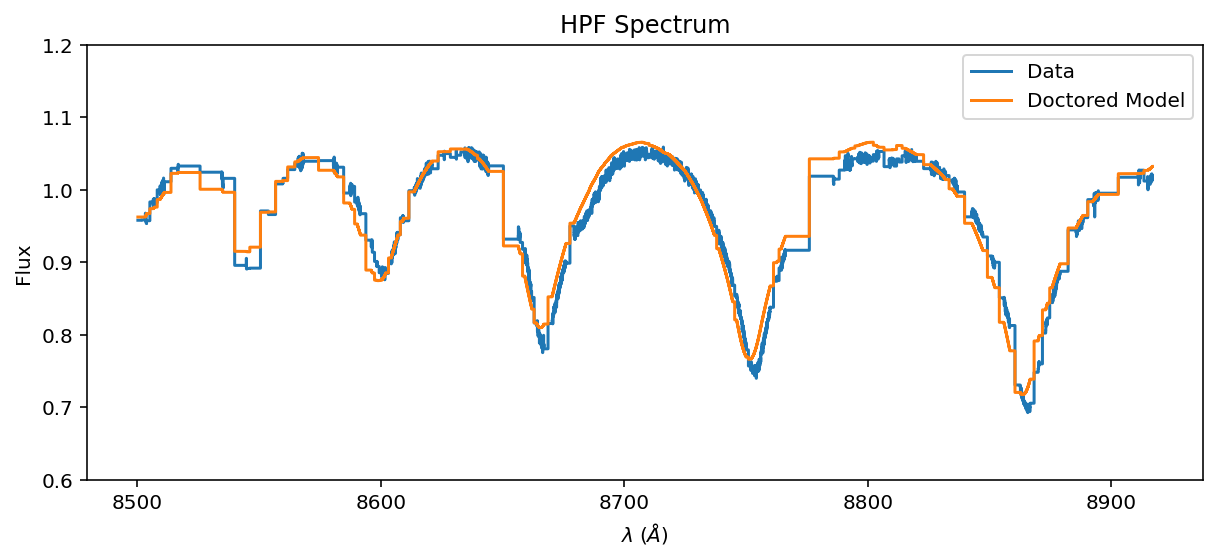

In [12]:
ax = data.plot(label='Data')
spec.plot(ax=ax, label='Doctored Model')
ax.legend();

You can see that our guess RV is off.  Let's do a grid search for $v\sin{i}$ and RV.

In [13]:
n_vsinis = 20
n_RVs = 20
vsinis = np.linspace(1, 150.0, n_vsinis)
RVs = np.linspace(-100.0, 100.0, n_RVs)

In [14]:
loss_values = np.zeros((n_vsinis, n_RVs))

We will compute the sum-of-the-squares-of-the-residuals ("chi-squared") for each value of $v\sin{i}$ and RV.

In [15]:
for i, vsini in tqdm(enumerate(vsinis), total=n_vsinis):
    for j, RV in enumerate(RVs):
            spec = template.rotationally_broaden(vsini)\
                .rv_shift(RV)\
                .instrumental_broaden(resolving_power=55_000)\
                .resample(data)\
                .normalize()
            residual = data.subtract(spec, handle_meta='ff')
            chi2_loss = np.sum(0.5*residual.flux.value**2/residual.uncertainty.array**2)

            loss_values[i,j] = chi2_loss

  0%|          | 0/20 [00:00<?, ?it/s]

The best fit values minimizes the chi-squared.

In [16]:
best_i, best_j = np.unravel_index(np.argmin(loss_values), loss_values.shape)

In [17]:
best_vsini, best_RV = vsinis[best_i], RVs[best_j]
best_RV, best_vsini

(15.789473684210535, 102.94736842105263)

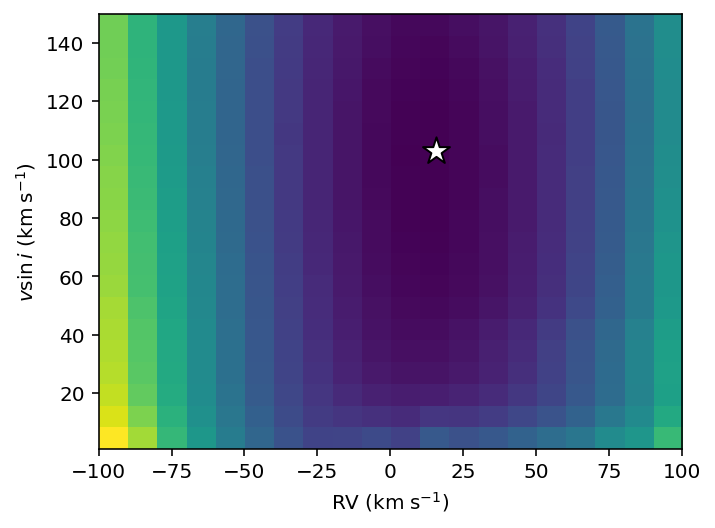

In [18]:
extent=[RVs.min(), RVs.max(), vsinis.min(), vsinis.max()]
plt.imshow(loss_values, extent=extent, aspect=1, origin='lower')
plt.scatter(best_RV,best_vsini,  marker='*', c='w', ec='k', s=200)
plt.xlabel('RV ($\mathrm{km}\;\mathrm{s}^{-1}$)')
plt.ylabel('$v\sin{i}$ ($\mathrm{km}\;\mathrm{s}^{-1}$)');

Awesome, we have found the RV and $v\sin{i}$ with the closest match to the data.

In [19]:
best_spec_full = template.rotationally_broaden(best_vsini)\
            .rv_shift(best_RV)\
            .instrumental_broaden(resolving_power=55_000)
best_spec = best_spec_full[data.wavelength.min():data.wavelength.max()].normalize()

How does the best fit look by-eye?

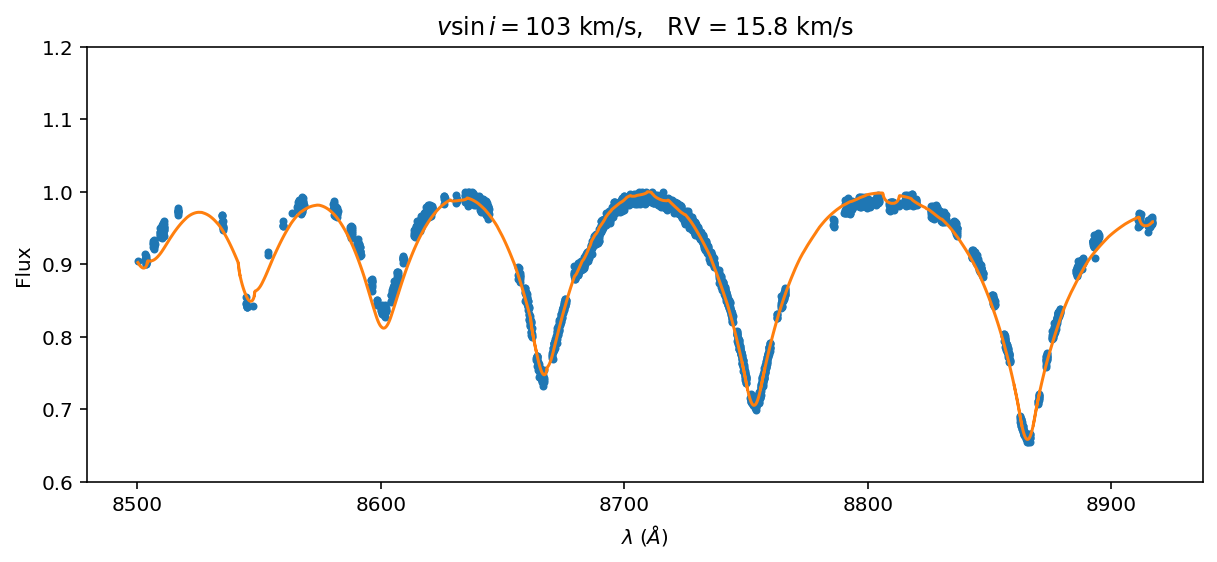

In [20]:
ax=(data/data.flux.max()).plot(marker='.', linestyle='None')
(best_spec/best_spec.flux.max()).plot(ax=ax)
title1 = '$v\sin{i} = $'+'{:0.0f}'.format(best_vsini)+' km/s,   '
title2 = 'RV = '+'{:0.1f}'.format(best_RV)+' km/s'
title = title1 + title2
ax.set_title(title);

Excellent!  That's much better than our initial guess.    
It's still not *perfect* because the model template has imperfections.